## Make dataloader

In [1]:
import sys
sys.path.append('/srv/user/turishcheva/experanto_video_dev/experanto/')
from experanto.data import Mouse2pVideoDataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict

/user/turishcheva/anaconda3/envs/sensorium/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !nvidia-smi

In [3]:
m = 'dynamic29712-5-9-Video-full' # mouse
path_pre = '/usr/users/agecker/datasets/funct_foundational_data/new_export_for_esperanto_dev/'

In [4]:
root_folder = f'{path_pre}{m}'

**Important**

* If the `stim_duration` is below 65 -> change skip parameter in the sensorium evaluation function (to 20, for default sensorium configularion)
https://github.com/ecker-lab/sensorium_2023/blob/main/sensorium/utility/scores.py#L10
* Also note that original sensorium was released in 36 x 64 resolution, 144 x 256 might require more GPU memory

In [5]:
train_dataset = Mouse2pVideoDataset(root_folder=root_folder,
        tier='train',
        stim_duration=30,
        sampling_rate=30,
        subsample=True,
        cut=True,
        add_channel=True,
        channel_pos=0,
        interp_config = {
            'screen' : {'rescale': True, 'normalize':True, },
            'responses' : {'keep_nans' : False, 
#                            'interpolation_mode' : 'nearest_neighbor',
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : False,
                           'normalize_std_threshold': 0.01
                          },
            'eye_tracker' : {'keep_nans' : False, 
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : True,
                           'normalize_std_threshold': None
                            },
            'treadmill' : {'keep_nans' : False, 
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : True,
                           'normalize_std_threshold': None
                          },
            }
                                   )

In [6]:
val_dataset = Mouse2pVideoDataset(
    root_folder,
    tier='oracle',
        stim_duration=30,
        sampling_rate=30,
        subsample=False, # this would start taking chunks from the begining always
        cut=False,
        add_channel=True,
        channel_pos=0,
        interp_config = {
            'screen' : {'rescale': True, 'normalize':True,},
            'responses' : {'keep_nans' : False, 
#                            'interpolation_mode' : 'nearest_neighbor',
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : False,
                           'normalize_std_threshold': 0.01
                          },
            'eye_tracker' : {'keep_nans' : False, 
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : True,
                           'normalize_std_threshold': None
                            },
            'treadmill' : {'keep_nans' : False, 
                           'interpolation_mode' : 'linear', 
                           'interp_window' : 5,
                           'normalize':True,
                           'normalize_subtract_mean' : True,
                           'normalize_std_threshold': None
                          },
            }
    )

In [16]:
batch_size = 1
# batch_size = 2
data_loaders = OrderedDict()

data_loaders['train'] = OrderedDict()
data_loaders['oracle'] = OrderedDict()
data_loaders['train'][m] =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loaders['oracle'][m] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
it =next(iter(data_loaders['train'][m]))
# time is always first dim

In [21]:
it.screen.shape

torch.Size([1, 1, 30, 144, 256])

In [22]:
it.responses.shape

torch.Size([1, 7939, 30])

In [23]:
it.eye_tracker.shape

torch.Size([1, 30, 4])

In [24]:
it.treadmill.shape

torch.Size([1, 30])

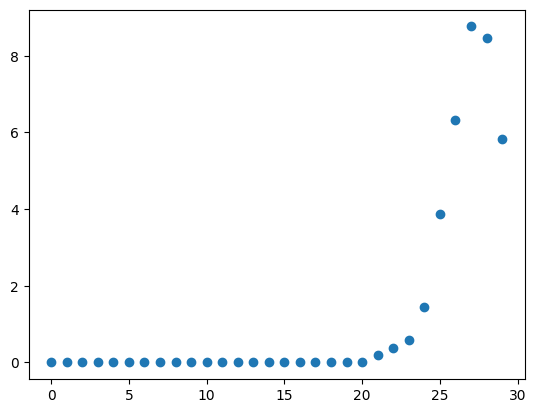

In [16]:
plt.plot(it.responses[0, 0], 'o')

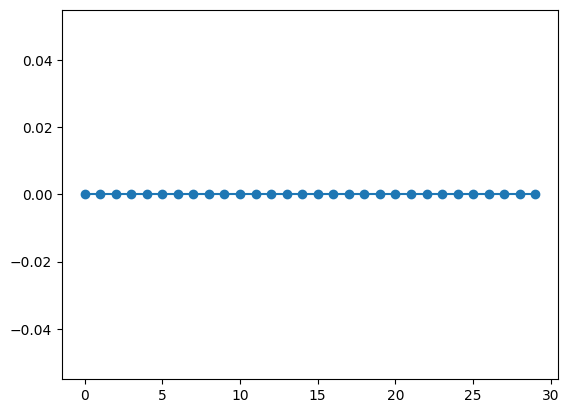

In [17]:
plt.plot(it.treadmill[0], '-o')

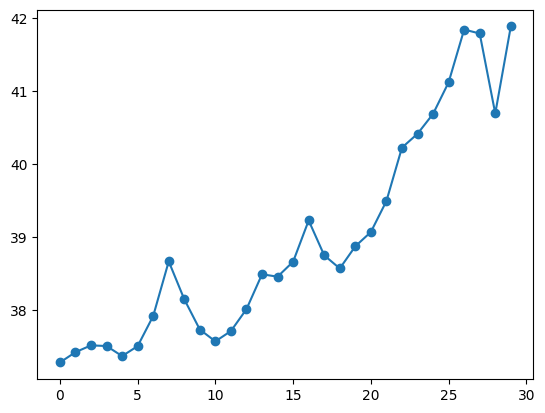

In [20]:
plt.plot(it.eye_tracker[0, :, 0], '-o')

In [21]:
train_dataset.neurons.cell_motor_coordinates

array([[-1357,  -467,   300],
       [-1369,  -478,   300],
       [-1304,  -480,   300],
       ...,
       [ -887,  -321,   225],
       [-1039,   118,   225],
       [-1249,  -321,   225]])

## Make and test forward pass for sensorium

In [25]:
seed = 42
import sys
sys.path.append('/srv/user/turishcheva/sensorium_replicate/sensorium_2023/')
sys.path.append('/srv/user/turishcheva/sensorium_replicate/neuralpredictors/')
import torch
from nnfabrik.utility.nn_helpers import set_random_seed
set_random_seed(seed)

from sensorium.datasets.mouse_video_loaders import mouse_video_loader
from sensorium.utility.scores import get_correlations
from nnfabrik.builder import get_trainer
from sensorium.models.make_model import make_video_model

In [26]:
factorised_3D_core_dict = dict(
    input_channels=1, # increase if behaviour is used
    hidden_channels=[32, 64, 128],
    spatial_input_kernel=(11,11),
    temporal_input_kernel=11,
    spatial_hidden_kernel=(5,5),
    temporal_hidden_kernel=5,
    stride=1,
    layers=3,
    gamma_input_spatial=10,
    gamma_input_temporal=0.01, 
    bias=True, 
    hidden_nonlinearities='elu', 
    x_shift=0, 
    y_shift=0,
    batch_norm=True, 
    laplace_padding=None,
    input_regularizer='LaplaceL2norm',
    padding=False,
    final_nonlin=True,
    momentum=0.7
)


shifter_dict=None


readout_dict = dict(
    bias=True,
    init_mu_range=0.2,
    init_sigma=1.0,
    gamma_readout=0.0,
    gauss_type='full',
#     grid_mean_predictor=None,
    grid_mean_predictor={
        'type': 'cortex',
        'input_dimensions': 2,
        'hidden_layers': 1,
        'hidden_features': 30,
        'final_tanh': True
    },
    share_features=False,
    share_grid=False,
    shared_match_ids=None,
    gamma_grid_dispersion=0.0,
)

In [27]:
factorised_3d_model = make_video_model(
    data_loaders,
    seed,
    core_dict=factorised_3D_core_dict,
    core_type='3D_factorised',
    readout_dict=readout_dict.copy(),
    readout_type='gaussian',               
    use_gru=False,
    gru_dict=None,
    use_shifter=False,
    shifter_dict=shifter_dict,
    shifter_type='MLP',
    deeplake_ds=False,
)

/srv/user/turishcheva/experanto_video_dev/experanto/experanto/interpolators.py:325: UserWarning: Image size changes aspect ratio.
  warnings.warn("Image size changes aspect ratio.")
/srv/user/turishcheva/sensorium_replicate/neuralpredictors/neuralpredictors/layers/cores/base.py:82: UserWarning: The batch_norm is applied to all layers
  warnings.warn(f"The {attr} is applied to all layers", UserWarning)
/srv/user/turishcheva/sensorium_replicate/neuralpredictors/neuralpredictors/layers/cores/base.py:82: UserWarning: The bias is applied to all layers
  warnings.warn(f"The {attr} is applied to all layers", UserWarning)
/srv/user/turishcheva/sensorium_replicate/neuralpredictors/neuralpredictors/layers/cores/base.py:82: UserWarning: The batch_norm_scale is applied to all layers
  warnings.warn(f"The {attr} is applied to all layers", UserWarning)
/srv/user/turishcheva/sensorium_replicate/neuralpredictors/neuralpredictors/layers/readouts/base.py:74: UserWarning: Use of 'gamma_readout' is deprec

In [28]:
factorised_3d_model

VideoFiringRateEncoder(
  (core): Factorized3dCore(
    (_input_weight_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (temporal_regularizer): DepthLaplaceL21d(
      (laplace): Laplace1d()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv_spatial): Conv3d(1, 32, kernel_size=(1, 11, 11), stride=(1, 1, 1))
        (conv_temporal): Conv3d(32, 32, kernel_size=(11, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer1): Sequential(
        (conv_spatial_1): Conv3d(32, 64, kernel_size=(1, 5, 5), stride=(1, 1, 1))
        (conv_temporal_1): Conv3d(64, 64, kernel_size=(5, 1, 1), stride=(1, 1, 1))
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0)
      )
      (layer2): Sequential(
        (conv_spatial_2): Conv3d(64, 128, kernel_size=(1, 5, 5), stride=

In [30]:
data_loaders

OrderedDict([('train',
              OrderedDict([('dynamic29712-5-9-Video-full',
                            <torch.utils.data.dataloader.DataLoader at 0x7f78dff9a100>)])),
             ('oracle',
              OrderedDict([('dynamic29712-5-9-Video-full',
                            <torch.utils.data.dataloader.DataLoader at 0x7f78dff9a2e0>)]))])

In [31]:
# device = 'cpu'
device = 'cuda:7'
torch.cuda.set_device(device)

In [32]:
# started at 18-24
trainer_fn = "sensorium.training.video_training_loop.standard_trainer"

trainer_config = {
    'dataloaders': data_loaders,
    'seed' : 111,
    'use_wandb' : False,
    'verbose': True,
    'lr_decay_steps': 4,
    'lr_init': 0.005,
    'device' : device,
    'detach_core' : False,
    
    # todo - put this to True if you are using deeplake
    # first connections to deeplake may take up for 10 mins
    'deeplake_ds' : False,
    'checkpoint_save_path': './loc2/',
    'max_iter': 3, # mock 5 epochs
                 }

trainer = get_trainer(trainer_fn=trainer_fn, 
                 trainer_config=trainer_config)

In [ ]:
# 19-11
validation_score, trainer_output, state_dict = trainer(factorised_3d_model)

optim_step_count = 1


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [01:38<00:00,  3.63it/s]


Epoch 1, Batch 358, Train loss -3636020.884074434, Validation loss -1556940.690668463
EPOCH=1  validation_correlation=0.004351403137395584


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [01:44<00:00,  3.44it/s]


## [Optional] Script to match tiers for new five sensorium mice

This works only for [these](https://gin.g-node.org/pollytur/sensorium_2023_dataset) five later released mice.  
For [these](https://gin.g-node.org/pollytur/sensorium_2023_data/src/798ba8ad041d8f0f0ce879af396d52c7238c2730) the `trial_idx.npy` file was not released, I am working on this matching and will update it when available

Current dataloader will not be able to handle the natural images partition of sensorium, but this was an OOD partition (live and final tests), so this should be fine so far

In [ ]:
import yaml
import os
from tqdm import tqdm
from collections import Counter

### Sessions without images

In [ ]:
path_to_old = ...
path_to_new = ...
path_to_save_matching = ...
for m in ['dynamic29515-10-12-Video-full', 'dynamic29712-5-9-Video-full']:
    matching = {}
    yaml_pre_path = f'{path_to_new}{m}/screen/meta/'
    tiers_prev = np.load(f'{path_to_old}{m.replace("full", "")}9b4f6a1a067fe51e15306b9628efea20/trials/tiers.npy')
    trial_idx_prev = np.asarray([int(i) for i in np.load(f'{path_to_old}{m.replace("full", "")}9b4f6a1a067fe51e15306b9628efea20/trials/trial_idx.npy')])
    
    for file in tqdm(os.listdir(yaml_pre_path)):
        with open(f'{yaml_pre_path}{file}', 'r') as f:
            data = yaml.safe_load(f)
        if data['modality'] != 'blank':
            if len(np.where(trial_idx_prev ==data['trial_idx'])[0]) ==0:
                matching[data['trial_idx']] = 'none'
            else:
                matching[data['trial_idx']] = tiers_prev[np.where(trial_idx_prev == data['trial_idx'])[0]][0]
    print(m)
    print(Counter(matching.values()))
    print(Counter(tiers_prev))
    print('\n\n')
    
    with open(f'{path_to_save_matching}/{m.replace("-Video-full", "_match")}.pkl', 'wb') as f:
        pickle.dump(matching, f)

### Sessions with images

In [ ]:
for m in ['dynamic29623-4-9-Video-full', 'dynamic29647-19-8-Video-full', 'dynamic29755-2-8-Video-full']:
    matching = {}
    yaml_pre_path = f'{path_to_new}{m}/screen/meta/'
    tiers_prev = np.load(f'{path_to_old}{m.replace("full", "")}9b4f6a1a067fe51e15306b9628efea20/trials/tiers.npy')
    trial_idx_prev_ = np.load(f'{path_to_old}{m.replace("full", "")}9b4f6a1a067fe51e15306b9628efea20/trials/trial_idx.npy')


    trial_idx_prev = []
    images = []
    imaged_idx = []
    not_found = []
    for idx, i in enumerate(trial_idx_prev_):
        if len(i.split('--')) == 1:
            trial_idx_prev.append(int(i))
        else:
            trial_idx_prev.append(-1)
            images.append([int(j) for j in i.split('--')])
            imaged_idx.append(idx)
    trial_idx_prev = np.asarray(trial_idx_prev)
    
    for file in tqdm(os.listdir(yaml_pre_path)):
        with open(f'{yaml_pre_path}{file}', 'r') as f:
            data = yaml.safe_load(f)
        if data['modality'] != 'blank':
            if len(np.where(trial_idx_prev ==data['trial_idx'])[0]) ==0:
                found = False
                for num, lst in enumerate(images):
                    if data['trial_idx'] in lst:
                        matching[data['trial_idx']] = tiers_prev[imaged_idx[num]]
                        found = True
                # assert found, f"id not found! {m} {file}"
                if not found:
                    not_found.append(file)
                    matching[data['trial_idx']] = 'none'
                    
            else:
                matching[data['trial_idx']] = tiers_prev[np.where(trial_idx_prev == data['trial_idx'])[0]][0]
    print(m)
    print(f'not found {len(not_found)}, len(matching)={len(matching)}, len(tiers_prev) = {len(tiers_prev)}')
    print(Counter(matching.values()))
    print(Counter(tiers_prev))
    
    print('\n\n')
    with open(f'{path_to_save_matching}{m.replace("-Video-full", "_match")}.pkl', 'wb') as f:
        pickle.dump(matching, f)

## [Optional] Script to get statistics

In [ ]:
sampling_dict = {
    'screen' : 30,
    'responses' : 8,
    'eye_tracker' : 20,
    'treadmill' : 100,
}

In [ ]:
for mod, sr in sampling_dict.items():
    ds = Mouse2pVideoDataset(root_folder=root_folder,
        tier='train',
        stim_duration=30,
        sampling_rate=sr,
        subsample=True,
        cut=False,
        add_channel=True,
        channel_pos=0,
        interp_config = {
            'screen' : {'rescale': True},
            'responses' : {'keep_nans' : True, 
                           'interpolation_mode' : 'nearest_neighbor', 
                           'interp_window' : 0,
                           'normalize':False,
                           'normalize_subtract_mean' : False,
                           'normalize_std_threshold': None
                          },
            
            'eye_tracker' : {'keep_nans' : False, 
                           'interpolation_mode' : 'nearest_neighbor', 
                           'interp_window' : 0,
                            'normalize':False,
                           'normalize_subtract_mean' : False,
                           'normalize_std_threshold': None
                            },
            'treadmill' : {'keep_nans' : False, 
                           'interpolation_mode' : 'nearest_neighbor', 
                           'interp_window' : 0,
                           'normalize':False,
                           'normalize_subtract_mean' : False,
                           'normalize_std_threshold': None
                          },
        })
    data_all = []
    for i in tqdm(range(len(ds))):
        data_all.append(np.squeeze(ds.__getitem__(i).screen))
    data_all = np.concatenate(data_all)                     
    means = np.nanmean(data_all, axis=0)
    stds = np.nanstd(data_all, axis=0, ddof=1)   
    if len(means.shape) == 0:
        means = means.reshape(-1)
        stds = stds.reshape(-1)
    elif len(means.shape) != 2:
        means = means.reshape(-1, 1)
        stds = means.reshape(-1, 1)
    np.save(f'{path_pre}{m}/{mod}/meta/means.npy', means)
    np.save(f'{path_pre}{m}/{mod}/meta/stds.npy', stds)                   